## basis on 3-1 hw

In [1]:
!pip install tensorflow-gpu==1.12

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import glob
import os

# To generate GIFs
!pip install imageio

# To use tf2.0
# !pip install tensorflow==2.0.0-alpha0

import PIL
import time 
import math
from IPython import display


In [3]:
import tensorflow as tf 

print(f"tf version:{tf.__version__}")
# assert tf.__version__ >="2.0"
tf.enable_eager_execution()

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


tf version:1.12.0


# Load and prepare the dataset
we use Anime dataset to try to generate anime pic by using vanilla GAN.

In [4]:
anime1 = glob.glob("AnimeDataset/faces/*")
anime2 = glob.glob("extra_data/images/*")

print(f"there is {len(anime1)} pics in anime1")
print(f"there is {len(anime2)} pics in anime2")

there is 33431 pics in anime1
there is 36740 pics in anime2


In [5]:
def read_data(data_list):
    """
    # input: 
    data_list
    
    # output:    
    numpy_array:(pics_number, w, h, c)
    
    """    
    #use list 
    start = time.time()
    data_array = []
    for i in data_list:
        data_array.append(plt.imread(i))
        
    print(f"time cost:{time.time() - start}")

    return np.array(data_array)
        

In [6]:
# train_images = read_data(anime1)
# np.save("anime1.npy", train_images)
#20:30 超久 四棵GPU
#20:40 4分鐘 
#20:52 2分鐘
#21.02 4分鐘
#21.30 2分半

#21.39 16 sec

train_images = np.load('anime1.npy')

# image preprocessing 

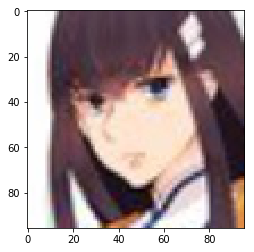

In [7]:

plt.imshow(train_images[3])
train_images = train_images.astype("float32")
train_images = (train_images - 127.5)/127.5 


In [8]:
train_images.nbytes

3697201152

# batch generator

In [9]:
BUFFER_SIZE = 33431
BATCH_SIZE = 128
W = 96
H = 96
C = 3
train_dataset = tf.data.Dataset.from_tensor_slices(train_images[:10240]).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



# Create the models

In [10]:
# class GAN():
#     def __init__(self):
#         super(GAN, self).__init__()
        
#         self.generator = tf.keras.Sequential([
#             tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
#             tf.keras.layers.BatchNormalization(),
#             tf.keras.layers.LeakyReLU(),
#             tf.keras.layers.Reshape((7,7,256)),
#             tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
#             tf.keras.layers.BatchNormalization(),
#             tf.keras.layers.LeakyReLU(),
#             tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
#             tf.keras.layers.BatchNormalization(),
#             tf.keras.layers.LeakyReLU(),
#             tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
#         ])
        
#         self.discriminator = tf.keras.Sequential([
#             tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
#             tf.keras.layers.LeakyReLU(),
#             tf.keras.layers.Dropout(0.4),
#             tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
#             tf.keras.layers.LeakyReLU(),
#             tf.keras.layers.Dropout(0.4),
#             tf.keras.layers.Flatten(),
#             tf.keras.layers.Dense(1)  
#         ])
        
#         def make_gen_image():
#             noise = tf.random.normal([1, 100])
#             return self.generator(noise, training = False)
        
#         def make_grade():
#             return self.discriminator(make_gen_image)
        

In [11]:
def generator_model():
    model = tf.keras.Sequential([
            tf.keras.layers.Dense(12*12*256, use_bias=False, input_shape=(100,)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Reshape((12,12,256)),
            tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid')
    ])
    
    return model

def discriminator_model():
    model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[96, 96, 3]),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
    ])
    return model 

In [12]:
gen = generator_model()
gen.summary()

dis = discriminator_model() 
dis.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 36864)             3686400   
_________________________________________________________________
batch_normalization (BatchNo (None, 36864)             147456    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 36864)             0         
_________________________________________________________________
reshape (Reshape)            (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 12, 12, 128)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12, 12, 128)       0         
__________

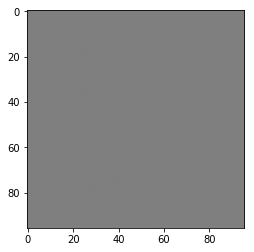

In [13]:
generator = generator_model()
noise = tf.random.normal([1,100])
generated_image = generator(noise, training = False)
plt.imshow(generated_image[0])

In [14]:
discriminator = discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.48890188]], shape=(1, 1), dtype=float32)


# Define the loss and optimizers

In [15]:
# cross_entropy = tf.keras.metrics.binary_crossentropy()

# Disciminator loss

def D_loss(real_output, fake_output):
    real_loss = tf.keras.metrics.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.metrics.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    
    return total_loss

# generator loss

def G_loss(fake_output):
    return tf.keras.metrics.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    

In [16]:
# optimizer

G_optimizer = tf.train.AdamOptimizer(1e-4)
D_optimizer = tf.train.AdamOptimizer(1e-4)

## save checkpoint

In [17]:
checkpoint_dir = './training_checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
        

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=G_optimizer,
                                 discriminator_optimizer=D_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Define the training loop

In [18]:
EPOCHS = 1000
noise_dim = 100
num_example_to_generate = 16

seed = tf.random.normal([num_example_to_generate, noise_dim])


In [19]:
# @tf.function

def train_step(image):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_image = generator(noise, training = True)
        
        real_output = discriminator(image, training = True)
        fake_output = discriminator(generated_image, training = True)
        
        gen_loss = G_loss(fake_output)
        disc_loss = D_loss(real_output, fake_output)
    
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    G_optimizer.apply_gradients(zip(gradient_of_generator, generator.trainable_variables))
    D_optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))
    
    
        

In [20]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
        
        display.clear_output(wait=True)
        generate_and_save_image(generator, epoch+1, seed)
        
        #save model every 15 epochs
        print(f"{epoch} end")
        if (epoch+1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        print(f"time for epoch {epoch+1} is {time.time() - start} sec")
        
    #generate after final epochs
    display.clear_output(wait = True)
    generate_and_save_image(generator, epochs, seed)

In [21]:
process_dir = './training_process'
if not os.path.exists(process_dir):
    os.makedirs(process_dir)
    

def generate_and_save_image(model, epoch, test_input):
    #notice that training should set to false as it is inference mode
    
    prediction = model(test_input, training = False)
#     prediction = tf.math.sigmoid(prediction)
    fig = plt.figure(figsize=(4,4))
    print(prediction[1])
    for i in range(prediction.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(prediction[i], vmin=0., vmax=1.)
        plt.axis("off")
        
    plt.savefig(process_dir + "/" + "image at epoch{:04d}".format(epoch))
    plt.show()
        

tf.Tensor(
[[[0.55388004 0.53289455 0.51267505]
  [0.593266   0.5374114  0.54026634]
  [0.611212   0.5477515  0.5360525 ]
  ...
  [0.74180955 0.6244929  0.5913065 ]
  [0.74832344 0.6451623  0.5845748 ]
  [0.68658525 0.60888606 0.5632335 ]]

 [[0.58129805 0.54055965 0.5475012 ]
  [0.63309306 0.57257795 0.56375635]
  [0.61726093 0.57920957 0.5636422 ]
  ...
  [0.7750151  0.66570365 0.5981539 ]
  [0.7688903  0.67865515 0.56759274]
  [0.724988   0.65278536 0.5779123 ]]

 [[0.6270286  0.57662237 0.548295  ]
  [0.66536754 0.5760458  0.59936535]
  [0.69107836 0.5769399  0.5751561 ]
  ...
  [0.8189254  0.66295975 0.56407684]
  [0.81002784 0.728368   0.554634  ]
  [0.75681    0.67278427 0.5886336 ]]

 ...

 [[0.6308183  0.57987237 0.5845514 ]
  [0.66628414 0.5858019  0.6064959 ]
  [0.6823926  0.63188916 0.6333215 ]
  ...
  [0.3777113  0.47276992 0.4466791 ]
  [0.4246925  0.4818208  0.49193838]
  [0.44519725 0.49936047 0.49412104]]

 [[0.64196765 0.6006273  0.5699758 ]
  [0.6546989  0.5956225  0

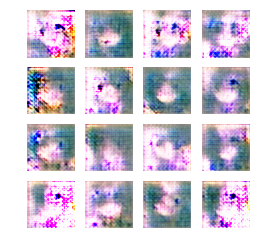

142 end
time for epoch 143 is 22.07324767112732 sec


KeyboardInterrupt: 

In [22]:
%%time
train(train_dataset, EPOCHS)